In [3]:
!pwd

/Users/heyuhao/Documents/GitHub/school_project/cz4042/assignment2/assignment2_question_b


In [1]:
!ls

other        part_b.ipynb temp.ipynb


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
import re
import string
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
import datetime
import matplotlib.pyplot as plt
import os

In [14]:
# MAX_DOCUMENT_LENGTH=100

# df_train = pd.read_csv('../train_medium.csv', names=['class', '_', 'text'], usecols=['class', 'text'])
# df_test = pd.read_csv('../test_medium.csv', names=['class', '_', 'text'], usecols=['class', 'text'])

# train_data = df_train.values
# test_data = df_test.values

# def clean_text(t):
#     #lowercase
#     t= t.lower()
#     #remove number and punctuation
#     t = re.sub(r'([^\w\s])|\d','',t)
#     #remove white space
#     t = re.sub(r'\s+',' ',t)
#     #remove stopwords
#     t = ' '.join([t for t in t.split(' ') if t not in stopwords])
#     t = t.strip()
#     return t

# for pair in train_data:
#     pair[1] = clean_text(pair[1])
# for pair in test_data:
#     pair[1] = clean_text(pair[1])
    
# train_data = np.array(train_data)
# test_data = np.array(test_data)
    
# x_train = pd.Series(train_data.T[1])
# y_train = pd.Series(train_data.T[0])
# x_test = pd.Series(test_data.T[1])
# y_test = pd.Series(test_data.T[0])

# char_processor = tf.contrib.learn.preprocessing.ByteProcessor(MAX_DOCUMENT_LENGTH)
# x_train = np.array(list(char_processor.fit_transform(x_train)))
# x_test = np.array(list(char_processor.transform(x_test)))
# y_train = np.array(y_train.values)
# y_test = np.array(y_test.values)

# ## save to nparray in data folder
# np.save(os.path.join('other', 'npy', 'x_train.npy'), x_train)
# np.save(os.path.join('other', 'npy', 'x_test.npy'), x_test)
# np.save(os.path.join('other', 'npy', 'y_train.npy'), y_train)
# np.save(os.path.join('other', 'npy', 'y_test.npy'), y_test)

## Load Data

In [4]:
x_train = np.load(os.path.join('other', 'npy', 'x_train.npy'), allow_pickle=True)
x_test = np.load(os.path.join('other', 'npy', 'x_test.npy'), allow_pickle=True)
y_train = np.load(os.path.join('other', 'npy', 'y_train.npy'), allow_pickle=True)
y_test = np.load(os.path.join('other', 'npy', 'y_test.npy'), allow_pickle=True)

## Class / Function

In [5]:
class TimeRecoder():
    start_time = 0
    end_time = 0
    
    def start(self):
        self.start_time = datetime.datetime.now()
        print('\n\n', '-'*10, ' START ', '-'*10, self.start_time, '\n\n')
        
    def end(self):
        self.end_time = datetime.datetime.now()
        print('\n\n', '-'*10, ' END ', '-'*10, self.end_time, '\n\n')
        self.checkTimeSpan()
        
    def checkTimeSpan(self):
        print('\n\n', '-'*10, ' TAKES ', '-'*10, self.end_time - self.start_time, '\n\n')

## Q1

In [8]:
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
no_epochs = 200
lr = 0.01

tf.reset_default_graph()

def char_cnn_model(x):
  
    input_layer = tf.reshape(
      tf.one_hot(x, 256), [-1, MAX_DOCUMENT_LENGTH, 256, 1])

    with tf.variable_scope('CNN_Layer1'):
        conv1 = tf.layers.conv2d(
            input_layer,
            filters=N_FILTERS,
            kernel_size=FILTER_SHAPE1,
            padding='VALID',
            activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(
            conv1,
            pool_size=POOLING_WINDOW,
            strides=POOLING_STRIDE,
            padding='SAME')
        
    with tf.variable_scope('CNN_Layer2'):
        conv2 = tf.layers.conv2d(
            pool1,
            filters=N_FILTERS,
            kernel_size=FILTER_SHAPE2,
            padding='VALID',
            activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(
            conv2,
            pool_size=POOLING_WINDOW,
            strides=POOLING_STRIDE,
            padding='SAME')

    dim = pool2.get_shape()[1].value * pool2.get_shape()[2].value * pool2.get_shape()[3].value 
    
    with tf.variable_scope('CNN_Flatten'):
        flatten = tf.reshape(pool2, [-1, dim])
    
    with tf.variable_scope('ANN'):
        W1 = tf.Variable(tf.truncated_normal([dim, MAX_LABEL], stddev=1.0/np.sqrt(dim)))
        b1 = tf.Variable(tf.zeros([MAX_LABEL]))
        logits = tf.matmul(flatten, W1) + b1


    return input_layer, conv1, pool1, conv2, pool2, flatten, logits

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

inputs, conv1, pool1, conv2, pool2, flatten, logits = char_cnn_model(x)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

print('input: ', sess.run([tf.shape(inputs)], {x: x_train, y_: y_train}))
print('conv1: ', sess.run([tf.shape(conv1)], {x: x_train, y_: y_train}))
print('pool1: ', sess.run([tf.shape(pool1)], {x: x_train, y_: y_train}))
print('conv2: ', sess.run([tf.shape(conv2)], {x: x_train, y_: y_train}))
print('pool2: ', sess.run([tf.shape(pool2)], {x: x_train, y_: y_train}))
print('flatten: ', sess.run([tf.shape(flatten)], {x: x_train, y_: y_train}))
print('logits: ', sess.run([tf.shape(logits)], {x: x_train, y_: y_train}))

# entropy_on_training = []
# accuracy_on_testing = []

timeRecoder = TimeRecoder()
timeRecoder.start()

# for e in range(no_epochs):
    
#     # training
#     _, loss_  = sess.run([train_op, entropy], {x: x_train, y_: y_train})
#     entropy_on_training.append(loss_)
    
#     # testing
#     predict = sess.run([logits], {x: x_test})
#     accuracy_on_testing.append(accuracy_score(list(y_test), list(np.argmax(np.array(predict[0]), axis=1))))
    
     
#     print('epoch %d: entropy: %f, accuracy: %f' % (e, entropy_on_training[-1], accuracy_on_testing[-1]))
    
timeRecoder.end()

# np.save(os.path.join('other', 'npy', 'entropy_on_training_q1.npy'), np.array(entropy_on_training))
# np.save(os.path.join('other', 'npy', 'accuracy_on_testing_q1.npy'), np.array(accuracy_on_testing))

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
input:  [array([5600,  100,  256,    1], dtype=int32)]
conv1:  [array([5600,   81,    1,   10], dtype=int32)]
pool1:  [array([5600,   41,    1,   10], dtype=int32)]
conv2:  [array([5600,   22,    1,   10], dtype=int32)]
pool2:  [array([5600,   11,    1,   10], dtype=int32)]
flatten:  [array([5600,  110], dtype=int32)]
logits:  [array([5600,   15], dtype=int32)]


 ----------  START  ---------- 2019-11-13 10:26:59.725430 




 ----------  END  ---------- 2019-11-13 10:26:59.725534 




 ----------  TAKES  ---------- 0:00:00.000104 




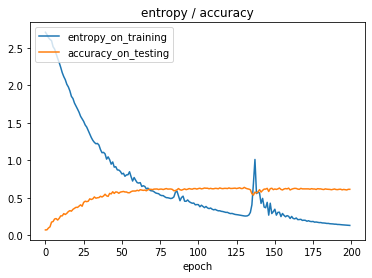

In [12]:
entropy_on_training = np.load(os.path.join('other', 'npy', 'entropy_on_training_q1.npy'), allow_pickle=True)
accuracy_on_testing = np.load(os.path.join('other', 'npy', 'accuracy_on_testing_q1.npy'), allow_pickle=True)

#plot
plt.figure()
plt.plot(entropy_on_training)
plt.plot(accuracy_on_testing)
plt.title('entropy / accuracy')
plt.xlabel('epoch')
plt.legend(['entropy_on_training', 'accuracy_on_testing',], loc='upper left')
plt.savefig(os.path.join('other', 'figure', 'q1.png'))

## Q2

In [13]:
MAX_DOCUMENT_LENGTH = 100
EMBEDDING_SIZE = 20
N_FILTERS = 10
FILTER_SHAPE1 = [20, 20]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

no_epochs = 100
lr = 0.01

tf.reset_default_graph()

def char_cnn_model(x):
  
    input_layer = tf.reshape(
      tf.one_hot(x, 256), [-1, MAX_DOCUMENT_LENGTH, 256])
    
    with tf.variable_scope('Embedding_Layer'):
        W1 = tf.Variable(tf.truncated_normal([256, EMBEDDING_SIZE], stddev=2.0/np.sqrt(256)))
        b1 = tf.Variable(tf.zeros([EMBEDDING_SIZE]))
        embedding = tf.nn.relu(tf.matmul(input_layer, W1) + b1)
        embedding = tf.reshape(embedding, [-1, MAX_DOCUMENT_LENGTH, EMBEDDING_SIZE, 1])

    with tf.variable_scope('CNN_Layer1'):
        conv1 = tf.layers.conv2d(
            embedding,
            filters=N_FILTERS,
            kernel_size=FILTER_SHAPE1,
            padding='VALID',
            activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(
            conv1,
            pool_size=POOLING_WINDOW,
            strides=POOLING_STRIDE,
            padding='SAME')
        
    with tf.variable_scope('CNN_Layer2'):
        conv2 = tf.layers.conv2d(
            pool1,
            filters=N_FILTERS,
            kernel_size=FILTER_SHAPE2,
            padding='VALID',
            activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(
            conv2,
            pool_size=POOLING_WINDOW,
            strides=POOLING_STRIDE,
            padding='SAME')

    dim = pool2.get_shape()[1].value * pool2.get_shape()[2].value * pool2.get_shape()[3].value 
    
    with tf.variable_scope('CNN_Flatten'):
        flatten = tf.reshape(pool2, [-1, dim])
    
    with tf.variable_scope('ANN'):
        W1 = tf.Variable(tf.truncated_normal([dim, MAX_LABEL], stddev=1.0/np.sqrt(dim)))
        b1 = tf.Variable(tf.zeros([MAX_LABEL]))
        logits = tf.matmul(flatten, W1) + b1


    return input_layer, embedding, conv1, pool1, conv2, pool2, flatten, logits

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

inputs, embedding, conv1, pool1, conv2, pool2, flatten, logits = char_cnn_model(x)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)


sess = tf.Session()
sess.run(tf.global_variables_initializer())


print('input: ', sess.run([tf.shape(inputs)], {x: x_train, y_: y_train}))
print('embedding: ', sess.run([tf.shape(embedding)], {x: x_train, y_: y_train}))
print('conv1: ', sess.run([tf.shape(conv1)], {x: x_train, y_: y_train}))
print('pool1: ', sess.run([tf.shape(pool1)], {x: x_train, y_: y_train}))
print('conv2: ', sess.run([tf.shape(conv2)], {x: x_train, y_: y_train}))
print('pool2: ', sess.run([tf.shape(pool2)], {x: x_train, y_: y_train}))
print('flatten: ', sess.run([tf.shape(flatten)], {x: x_train, y_: y_train}))
print('logits: ', sess.run([tf.shape(logits)], {x: x_train, y_: y_train}))

# entropy_on_training = []
# accuracy_on_testing = []

timeRecoder = TimeRecoder()
timeRecoder.start()

# for e in range(no_epochs):
    
#     # training
#     _, loss_  = sess.run([train_op, entropy], {x: x_train, y_: y_train})
#     entropy_on_training.append(loss_)
    
#     # testing
#     predict = sess.run([logits], {x: x_test})
#     accuracy_on_testing.append(accuracy_score(list(y_test), list(np.argmax(np.array(predict[0]), axis=1))))
    
     
#     print('epoch %d: entropy: %f, accuracy: %f' % (e, entropy_on_training[-1], accuracy_on_testing[-1]))
    
timeRecoder.end()

# np.save(os.path.join('data', 'entropy_on_training_q2.npy'), np.array(entropy_on_training))
# np.save(os.path.join('data', 'accuracy_on_testing_q2.npy'), np.array(accuracy_on_testing))

input:  [array([5600,  100,  256], dtype=int32)]
embedding:  [array([5600,  100,   20,    1], dtype=int32)]
conv1:  [array([5600,   81,    1,   10], dtype=int32)]
pool1:  [array([5600,   41,    1,   10], dtype=int32)]
conv2:  [array([5600,   22,    1,   10], dtype=int32)]
pool2:  [array([5600,   11,    1,   10], dtype=int32)]
flatten:  [array([5600,  110], dtype=int32)]
logits:  [array([5600,   15], dtype=int32)]


 ----------  START  ---------- 2019-11-13 10:35:56.851149 




 ----------  END  ---------- 2019-11-13 10:35:56.851263 




 ----------  TAKES  ---------- 0:00:00.000114 


